In [ ]:
# Cell 1: imports
import re
import numpy as np
import pandas as pd
from collections import OrderedDict
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import io
from collections import defaultdict
from sklearn.model_selection import KFold
from matplotlib.patches import Patch
from IPython.display import display
from Bayesian import (learn_cpts_from_data, save_cpts_to_csv, parse_cpt_values,
                      get_probability, infer_posterior, visualize_bayesian_network,
                      log_likelihood, node_prediction_accuracy, bic, get_parents_map_from_cpts, load_cpts_from_csv,
                      visualize_bn_with_cpts, visualize_cpt_table)
from data.generator import sample
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# sample(r"data\sachs.bif\sachs.bif", 5500, r"data\sachs.bif\sachs.csv")

In [2]:
# Cell 2: load data
# Ganti path sesuai lokasimu
DATA_PATH = r"data\sachs.bif\sachs.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()
# Pastikan kolom adalah node names dan nilai state seperti 'LOW','AVG','HIGH'


Shape: (5500, 12)


,Unnamed: 0,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC,Plcg,Raf
0,0,AVG,AVG,AVG,HIGH,LOW,LOW,LOW,LOW,LOW,LOW,HIGH
1,1,AVG,AVG,AVG,LOW,LOW,LOW,HIGH,AVG,AVG,LOW,LOW
2,2,LOW,AVG,AVG,LOW,LOW,LOW,AVG,AVG,HIGH,LOW,LOW
3,3,AVG,HIGH,AVG,HIGH,LOW,LOW,HIGH,LOW,LOW,LOW,HIGH
4,4,LOW,AVG,LOW,LOW,LOW,LOW,AVG,HIGH,LOW,LOW,AVG


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5500 non-null   int64 
 1   Akt         5500 non-null   object
 2   Erk         5500 non-null   object
 3   Jnk         5500 non-null   object
 4   Mek         5500 non-null   object
 5   P38         5500 non-null   object
 6   PIP2        5500 non-null   object
 7   PIP3        5500 non-null   object
 8   PKA         5500 non-null   object
 9   PKC         5500 non-null   object
 10  Plcg        5500 non-null   object
 11  Raf         5500 non-null   object
dtypes: int64(1), object(11)
memory usage: 515.8+ KB


In [4]:
# Cell 3: EDA
df = df.drop(columns=['Unnamed: 0'])  # drop index column if exists
print("Unique values per node (sample):")
for col in df.columns:
    print(col, df[col].unique())
# frequency counts for a selected node
df['PKA'].value_counts()

Unique values per node (sample):
Akt ['AVG' 'LOW' 'HIGH']
Erk ['AVG' 'HIGH' 'LOW']
Jnk ['AVG' 'LOW' 'HIGH']
Mek ['HIGH' 'LOW' 'AVG']
P38 ['LOW' 'HIGH' 'AVG']
PIP2 ['LOW' 'HIGH' 'AVG']
PIP3 ['LOW' 'HIGH' 'AVG']
PKA ['LOW' 'AVG' 'HIGH']
PKC ['LOW' 'AVG' 'HIGH']
Plcg ['LOW' 'HIGH' 'AVG']
Raf ['HIGH' 'LOW' 'AVG']


PKA
AVG     3918
LOW     1029
HIGH     553
Name: count, dtype: int64

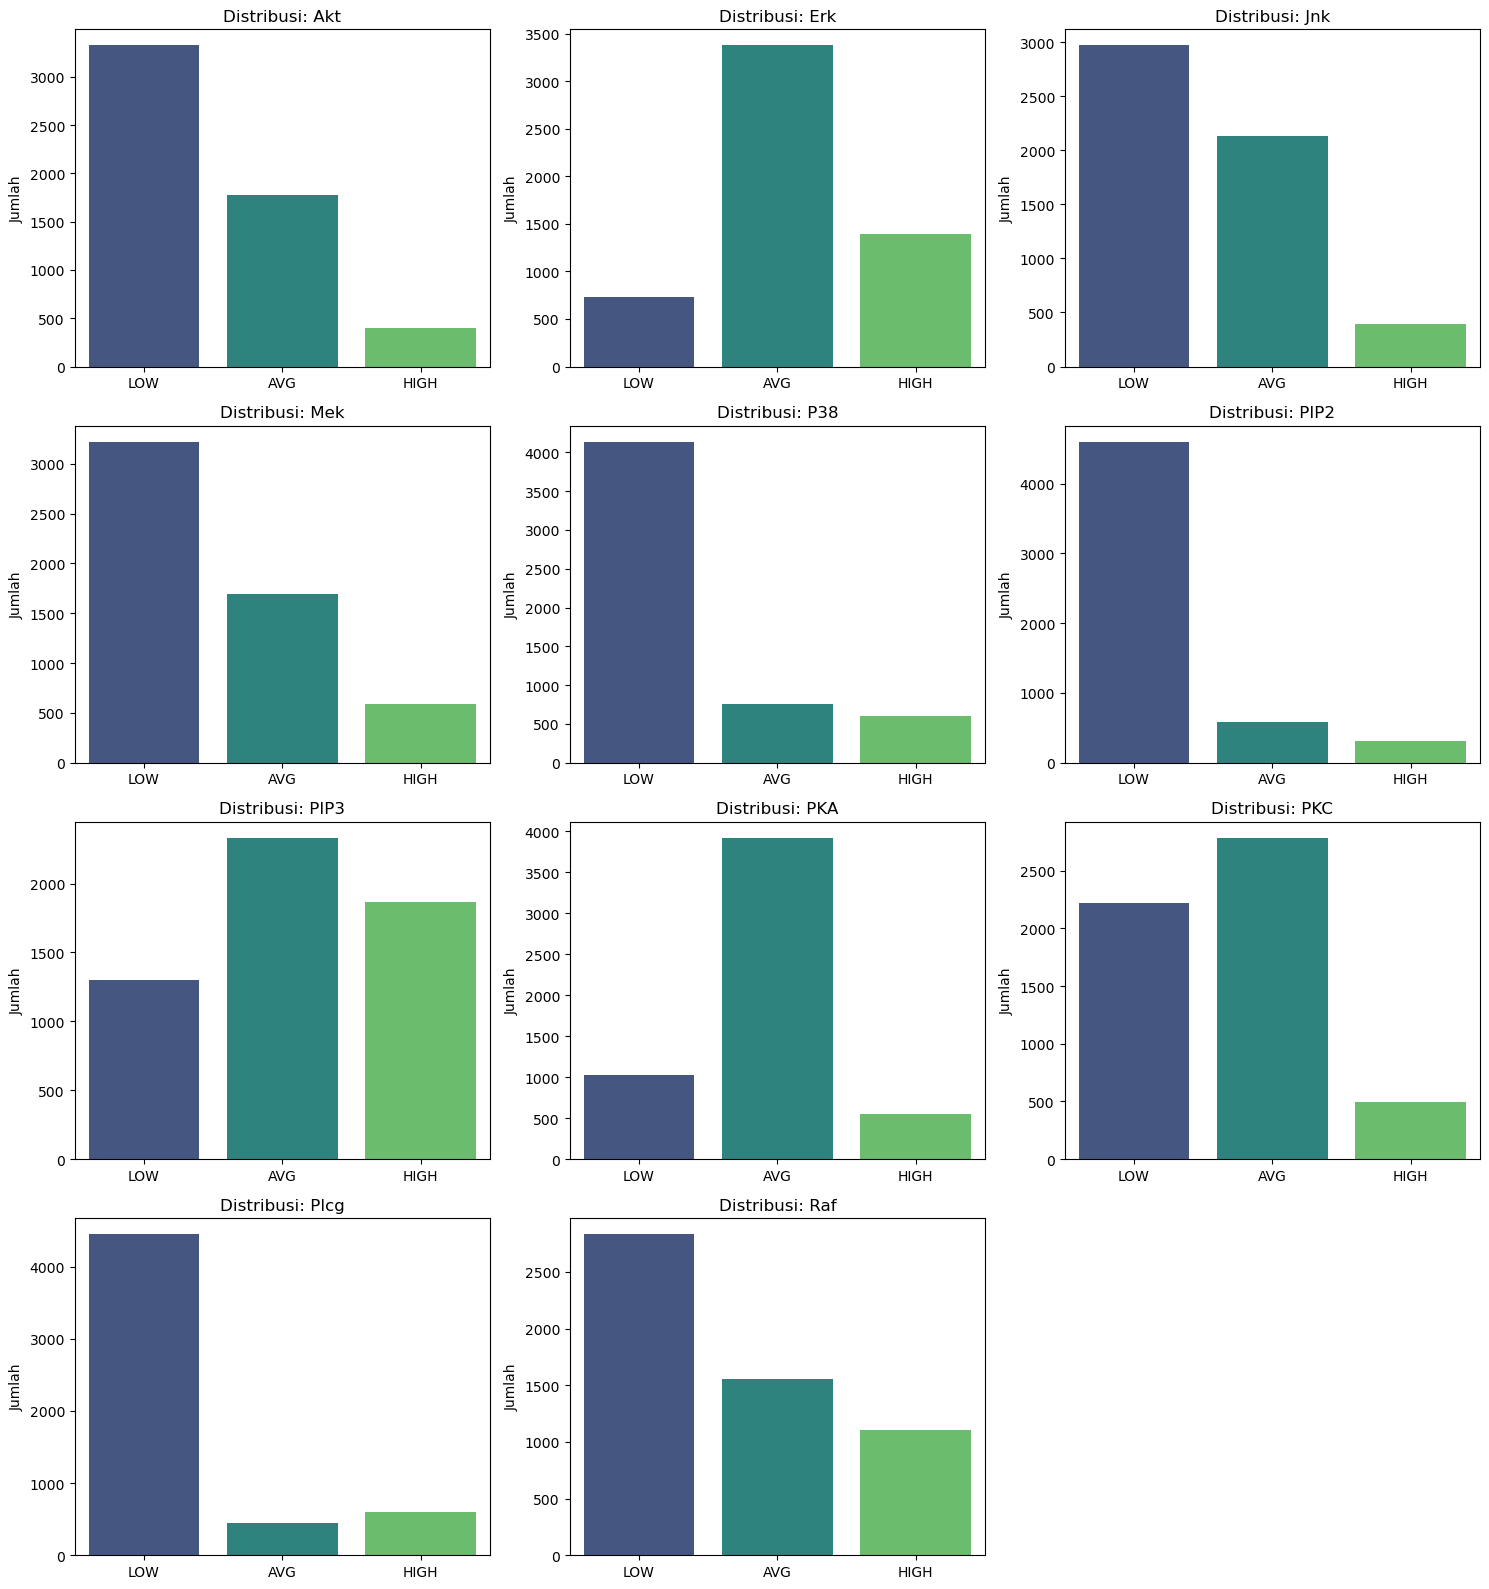

In [5]:
n_cols_plot = 3
n_rows_plot = math.ceil(len(df.columns) / n_cols_plot)
fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, 4 * n_rows_plot))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    sns.countplot(x=col, data=df, ax=axes[i], palette='viridis', order=['LOW', 'AVG', 'HIGH'])
    axes[i].set_title(f"Distribusi: {col}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Jumlah')
for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

In [6]:
df_numeric = df.copy()
mappings = {}
ordinal_map = {'LOW': 0, 'AVG': 1, 'HIGH': 2}

In [7]:
for col in df_numeric.columns:
    if df_numeric[col].dtype == 'object':
        if set(df_numeric[col].unique()).issubset(set(ordinal_map.keys())):
            df_numeric[col] = df_numeric[col].map(ordinal_map)
            mappings[col] = ordinal_map
        else:
            df_numeric[col], unique = pd.factorize(df_numeric[col], sort=True)
            mappings[col] = {v: k for k, v in enumerate(unique)}

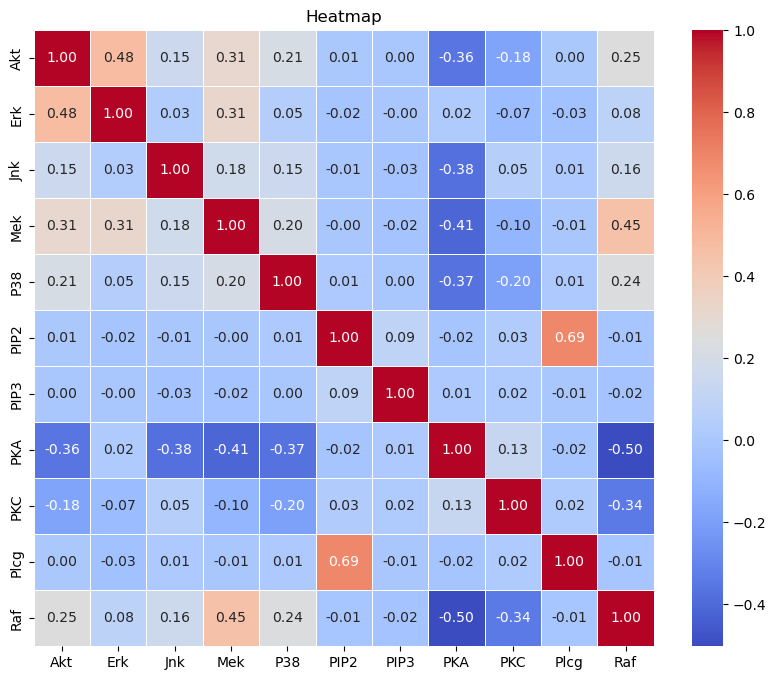

In [8]:
plt.figure(figsize=(10, 8))
corr_matrix = df_numeric.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap")
plt.show()

In [9]:
# Cell 4: parents map (jika belum ada, tulis manual sesuai struktur Sachs)
# Contoh (sesuaikan dengan struktur BIF yang kamu punya)
parents_map = {
    'PKC': [],
    'Plcg': [],
    'PKA': ['PKC'],
    'PIP3': ['Plcg'],
    'Raf': ['PKA', 'PKC'],
    'Jnk': ['PKA', 'PKC'],
    'P38': ['PKA', 'PKC'],
    'Mek': ['PKA', 'PKC', 'Raf'],
    'Erk': ['Mek', 'PKA'],
    'PIP2': ['PIP3', 'Plcg'],
    'Akt': ['Erk', 'PKA'],
}
node_list = list(df.columns)
# States: kalau semua sama
states = ['LOW','AVG','HIGH']


In [10]:
# Cell 5: belajar CPTs (MLE) dan simpan
cpts_map, node_states = learn_cpts_from_data(df, node_list, states, parents_map, laplace=1.0)
save_cpts_to_csv(cpts_map, r"data\sachs.bif\sachs_cpts_gen.csv")
print("Saved sachs_cpts_gen.csv")
# sample: print few entries
for k, v in list(cpts_map.items())[:6]:
    print(k, "len=", len(v), "->", v[:9])

Saved sachs_cpts_gen.csv
('Akt', ('Erk', 'PKA')) len= 27 -> [0.65, 0.3472222222222222, 0.002777777777777778, 0.5348837209302325, 0.4622093023255814, 0.0029069767441860465, 0.8235294117647058, 0.14705882352941177, 0.029411764705882353]
('Erk', ('Mek', 'PKA')) len= 27 -> [0.8355437665782494, 0.15649867374005305, 0.007957559681697613, 0.11948051948051948, 0.6887445887445888, 0.19177489177489176, 0.058823529411764705, 0.6875, 0.2536764705882353]
('Jnk', ('PKA', 'PKC')) len= 27 -> [0.3039332538736591, 0.23361144219308702, 0.46245530393325385, 0.5736842105263158, 0.42105263157894735, 0.005263157894736842, 0.1111111111111111, 0.7777777777777778, 0.1111111111111111]
('Mek', ('PKA', 'PKC', 'Raf')) len= 81 -> [0.7457627118644068, 0.23728813559322035, 0.01694915254237288, 0.29838709677419356, 0.0967741935483871, 0.6048387096774194, 0.283987915407855, 0.0030211480362537764, 0.7129909365558912]
('P38', ('PKA', 'PKC')) len= 27 -> [0.3182359952324195, 0.054827175208581644, 0.6269368295589988, 0.65263

In [11]:
# Cell 6: optionally load the provided sachs_cpts.csv and parse into cpts_map
cpts_file = r"data\sachs.bif\sachs_cpts_gen.csv"  # file original (if ada)
cpts_loaded = load_cpts_from_csv(cpts_file)
print("Loaded", len(cpts_loaded), "CPT entries from file.")


Loaded 11 CPT entries from file.


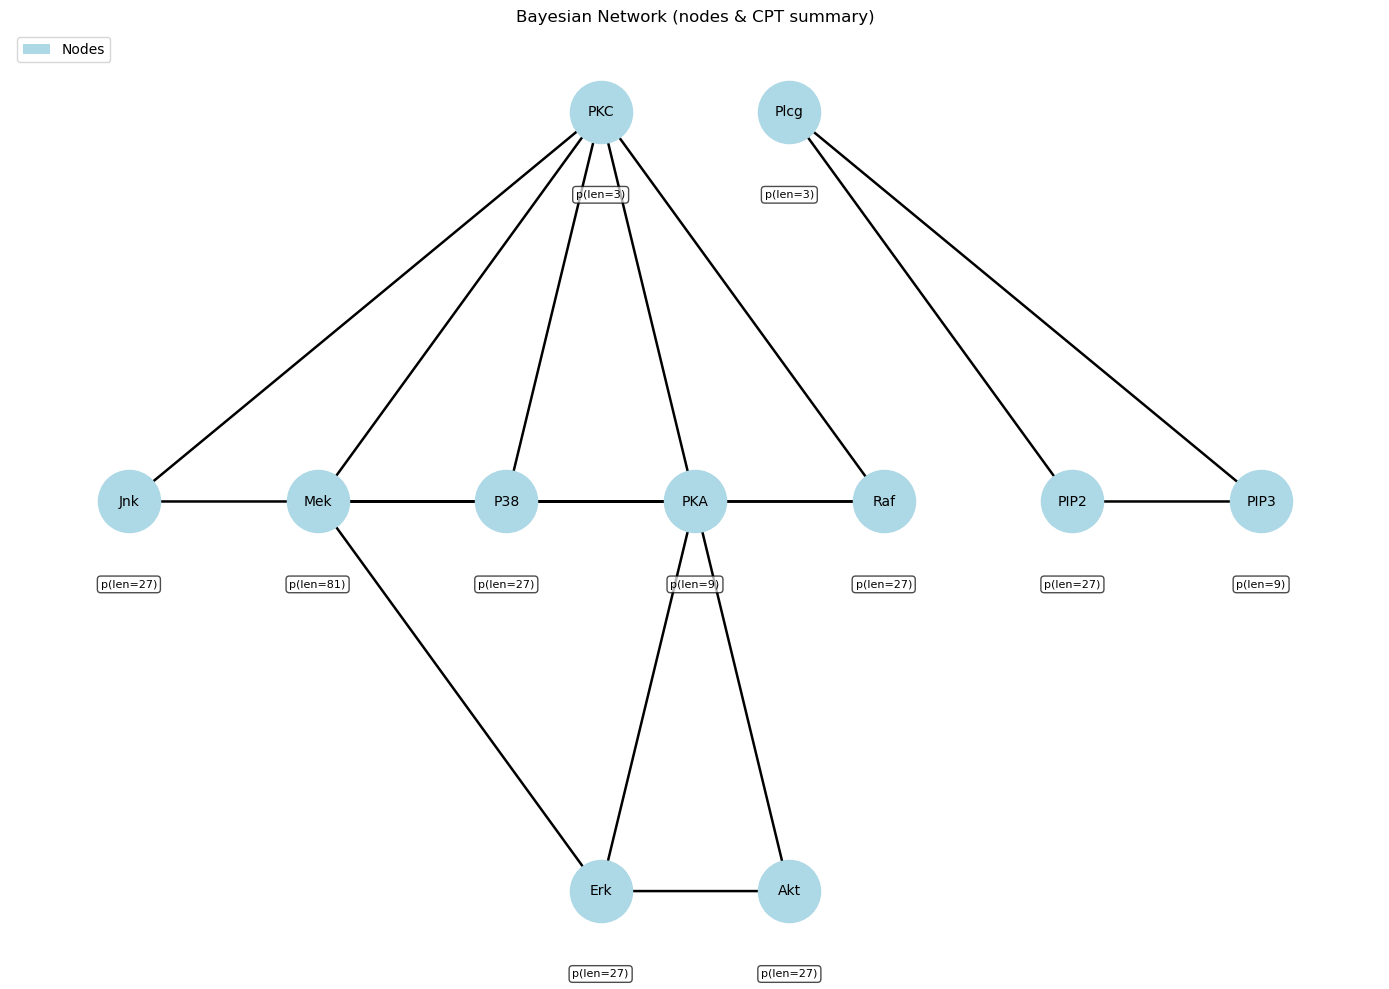

CPT for node: Akt
Parents: ['Erk', 'PKA']


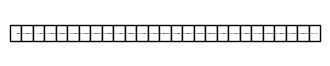

CPT for node: Erk
Parents: ['Mek', 'PKA']


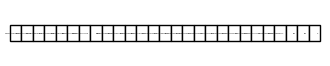

CPT for node: Jnk
Parents: ['PKA', 'PKC']


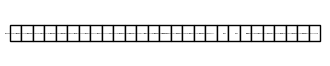

CPT for node: Mek
Parents: ['PKA', 'PKC', 'Raf']


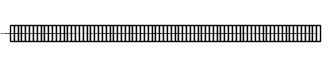

CPT for node: P38
Parents: ['PKA', 'PKC']


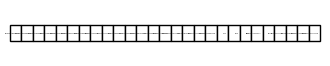

CPT for node: PIP2
Parents: ['PIP3', 'Plcg']


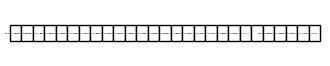

CPT for node: PIP3
Parents: ['Plcg']


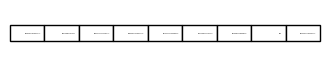

CPT for node: PKA
Parents: ['PKC']


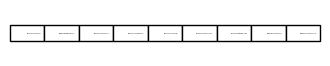

CPT for node: PKC
Parents: []


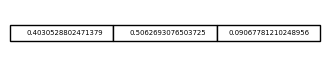

CPT for node: Plcg
Parents: []


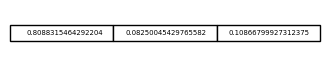

CPT for node: Raf
Parents: ['PKA', 'PKC']


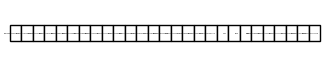

In [12]:
# Cell 7: visualize
visualize_bayesian_network(cpts_loaded, node_states, show_cpt_full=False, figsize=(14,10))
for (node, parents), cpt in cpts_loaded.items():
    visualize_cpt_table(node, list(parents), cpt)


In [13]:
# Cell 8: evaluasi
ll = log_likelihood(df, node_states, cpts_map)
accs = node_prediction_accuracy(df, node_states, cpts_map)
bic_val = bic(df, node_states, cpts_map)
print("Log-Likelihood:", ll)
print("BIC:", bic_val)
print("Per-node prediction accuracy (on same data):")
for node, a in accs.items():
    print(f"  {node}: {a:.4f}")

Log-Likelihood: -39581.492839864884
BIC: 80696.01127980703
Per-node prediction accuracy (on same data):
  Akt: 0.7976
  Erk: 0.7207
  Jnk: 0.6425
  Mek: 0.7498
  P38: 0.7993
  PIP2: 0.8804
  PIP3: 0.4711
  PKA: 0.7124
  PKC: 0.5064
  Plcg: 0.8091
  Raf: 0.6276


In [14]:
# Cell 9: k-fold CV untuk log-likelihood and accuracy
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lls = []
accs_list = []
for train_idx, test_idx in kf.split(df):
    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_test = df.iloc[test_idx].reset_index(drop=True)
    cpts_tr, node_states_tr = learn_cpts_from_data(df_train, node_list, states, parents_map, laplace=1.0)
    ll_test = log_likelihood(df_test, node_states_tr, cpts_tr)
    accs_test = node_prediction_accuracy(df_test, node_states_tr, cpts_tr)
    lls.append(ll_test)
    accs_list.append(accs_test)
print("CV log-likelihood per fold:", lls)
# aggregate accuracies
agg = defaultdict(list)
for d in accs_list:
    for k,v in d.items():
        agg[k].append(v)
print("Mean per-node CV accuracy:")
for k,vals in agg.items():
    print(k, np.mean(vals))


CV log-likelihood per fold: [np.float64(-7903.803552955181), np.float64(-8000.290551179901), np.float64(-7945.14941780447), np.float64(-7918.117844735143), np.float64(-7943.658851262678)]
Mean per-node CV accuracy:
Akt 0.7976363636363637
Erk 0.7205454545454545
Jnk 0.6425454545454545
Mek 0.749090909090909
P38 0.7992727272727272
PIP2 0.8776363636363638
PIP3 0.4670909090909091
PKA 0.7123636363636363
PKC 0.5063636363636362
Plcg 0.809090909090909
Raf 0.6256363636363637


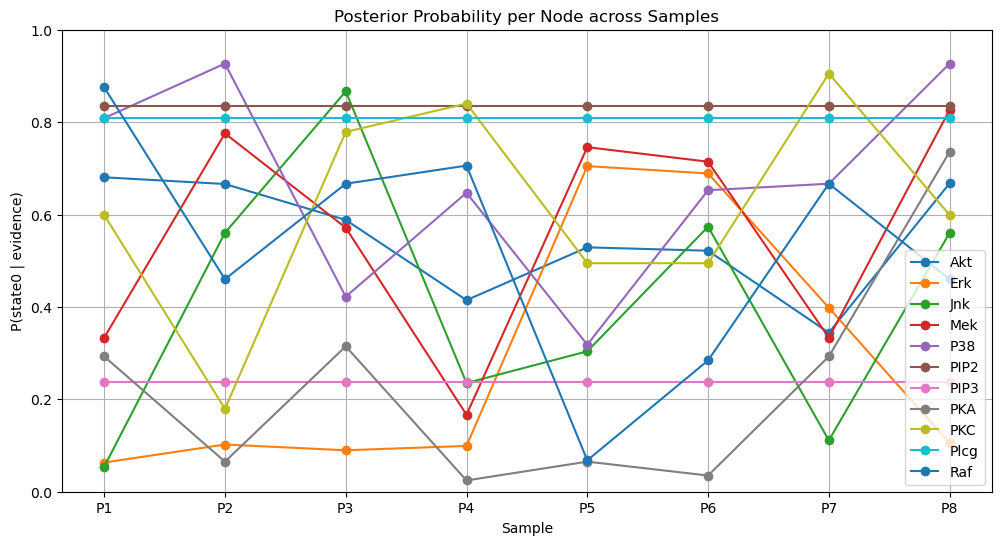

In [15]:
# Cell 10 — Multi-node line chart seperti contoh
samples = [
    {'PKC':'HIGH','PKA':'AVG','Raf':'HIGH'},   # P1
    {'PKC':'LOW','PKA':'AVG','Raf':'LOW'},    # P2
    {'PKC':'AVG','PKA':'HIGH','Raf':'HIGH'},  # P3
    {'PKC':'HIGH','PKA':'HIGH','Raf':'AVG'},  # P4
    {'PKC':'LOW','PKA':'LOW','Raf':'LOW'},    # P5
    {'PKC':'AVG','PKA':'LOW','Raf':'LOW'},    # P6
    {'PKC':'HIGH','PKA':'LOW','Raf':'HIGH'},  # P7
    {'PKC':'LOW','PKA':'AVG','Raf':'HIGH'}    # P8
]

X = [f"P{i+1}" for i in range(len(samples))]   # label X-axis
node_values = {node: [] for node in node_list}

# hitung posterior untuk tiap sample & node
for ev in samples:
    for node in node_list:
        post = infer_posterior(node, ev, node_states, cpts_loaded)
        state0 = node_states[node][0]          # ambil state pertama
        node_values[node].append(post[state0])

# plotting
plt.figure(figsize=(12,6))

for node, values in node_values.items():
    plt.plot(X, values, marker='o', label=node)

plt.title("Posterior Probability per Node across Samples")
plt.ylim(0,1)
plt.xlabel("Sample")
plt.ylabel("P(state0 | evidence)")
plt.legend()
plt.grid(True)
plt.show()


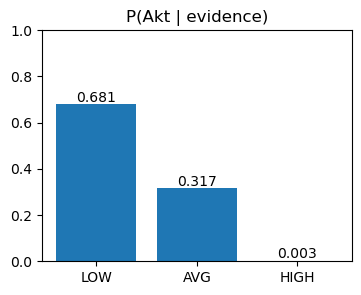

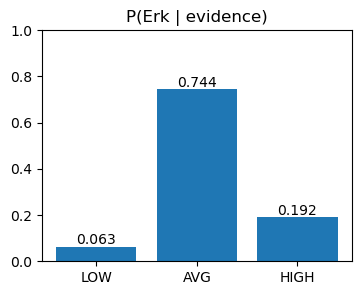

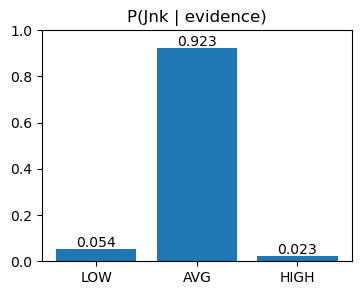

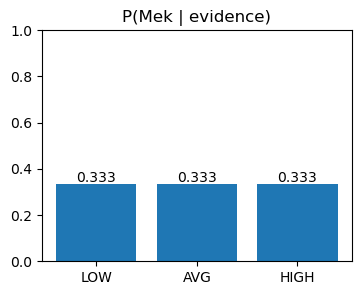

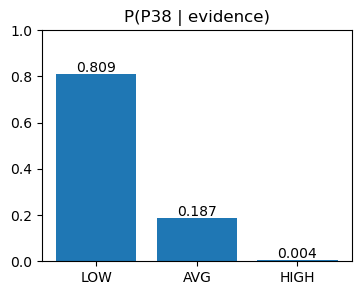

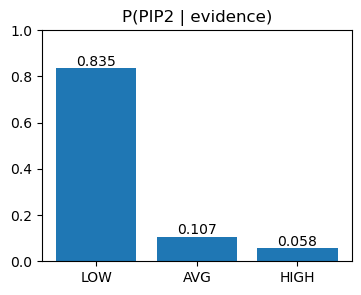

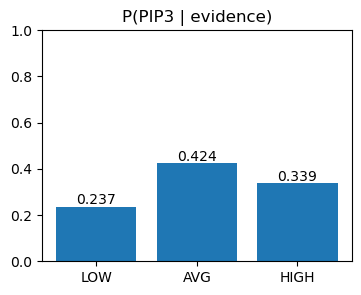

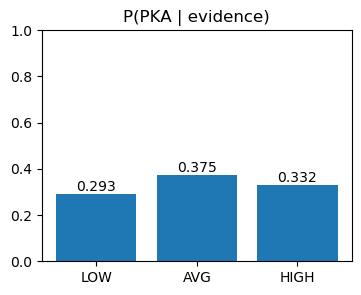

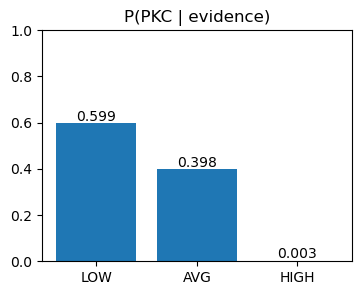

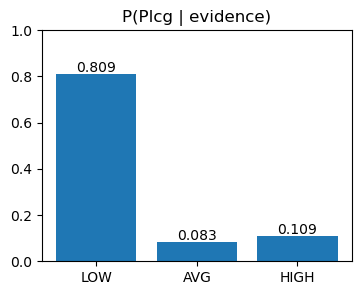

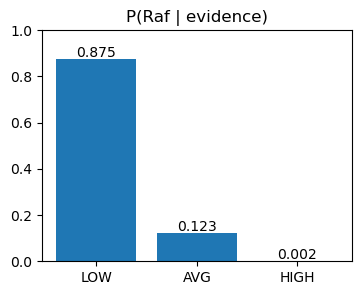

In [16]:
# Cell 10: inference & plot posterior per node given evidence
evidence = {'PKC':'HIGH','PKA':'AVG','Raf':'HIGH'}  # contoh

for node in sorted(node_list):
    post = infer_posterior(node, evidence, node_states, cpts_loaded)
    # bar plot
    plt.figure(figsize=(4,3))
    states_order = node_states[node]
    probs = [post.get(s, 0.0) for s in states_order]
    plt.bar(states_order, probs)
    plt.ylim(0,1)
    plt.title(f"P({node} | evidence)")
    for i,v in enumerate(probs):
        plt.text(i, v+0.01, f"{v:.3f}", ha='center')
    plt.show()
